8ноя23
# Методы кластеризации. Метод k средних. Начало
В анализе данных очень важное место занимает кластеризация данных. Если своими словами, кластеризация – разделение выборки на кластеры, то есть на участки, схожие по свойствам. На [википедии](https://www.youtube.com/watch?v=dQw4w9WgXcQ) написано подробно, но не очень понятно.

Сегодняшний урок посвящен одному конкретному алгоритму кластеризации – Методу k средних. <br/> Основная идея этого метода — итеративное повторение двух шагов:
1. Распределение объектов выборки по кластерам
2. Пересчёт центров кластеров 

Закономерно может возникнуть вопрос: "А где же это используется?". Хороший пример – Яндекс Такси. Когда вызываешь такси, приложение предлагает поставить место вызова такси в одну из заранее заготовленных точек.

<img src="https://raw.githubusercontent.com/teacher57/data_analysis_course/main/files/l6p1.jpg" width="500" height="500">

Эти точки не прописываются человеком, это обьединение многих разных мест вызова такси в вышеупомянутые кластеры.


В начале работы алгоритма выбираются *K* случайных центров в пространстве признаков. Каждый объект выборки относят к тому кластеру, к центру которого объект оказался ближе. Далее центры кластеров пересчитывают как среднее арифметическое векторов признаков всех вошедших в этот кластер объектов (то есть центр масс кластера). Как только мы обновили центры кластеров, объекты заново перераспределяются по ним, а затем можно снова уточнить положение центров. Процесс продолжается до тех пор, пока центры кластеров не перестанут меняться.


In [1]:
# импортирую библиотеки, не обращай внимания

import lib.l6 as l6

from pandas import Series, DataFrame, read_csv
import matplotlib.pyplot as plt
import random as r
import numpy as np
%matplotlib notebook

In [2]:
# создаю выборку
df = l6.gen(3, 3, 1000, s=1).drop("cluster", axis=1)
df

,a,b,c
0,23.930622,45.092272,47.516331
1,17.903794,50.761324,44.080893
2,25.025400,48.884737,51.659121
3,55.853393,77.206360,-1.510056
4,75.754164,74.613253,1.733055
...,...,...,...
995,59.862354,91.319482,12.400906
996,77.356163,73.099419,8.895489
997,56.228739,65.509968,10.863755
998,9.779675,81.483200,42.114361


<IPython.core.display.Javascript object>


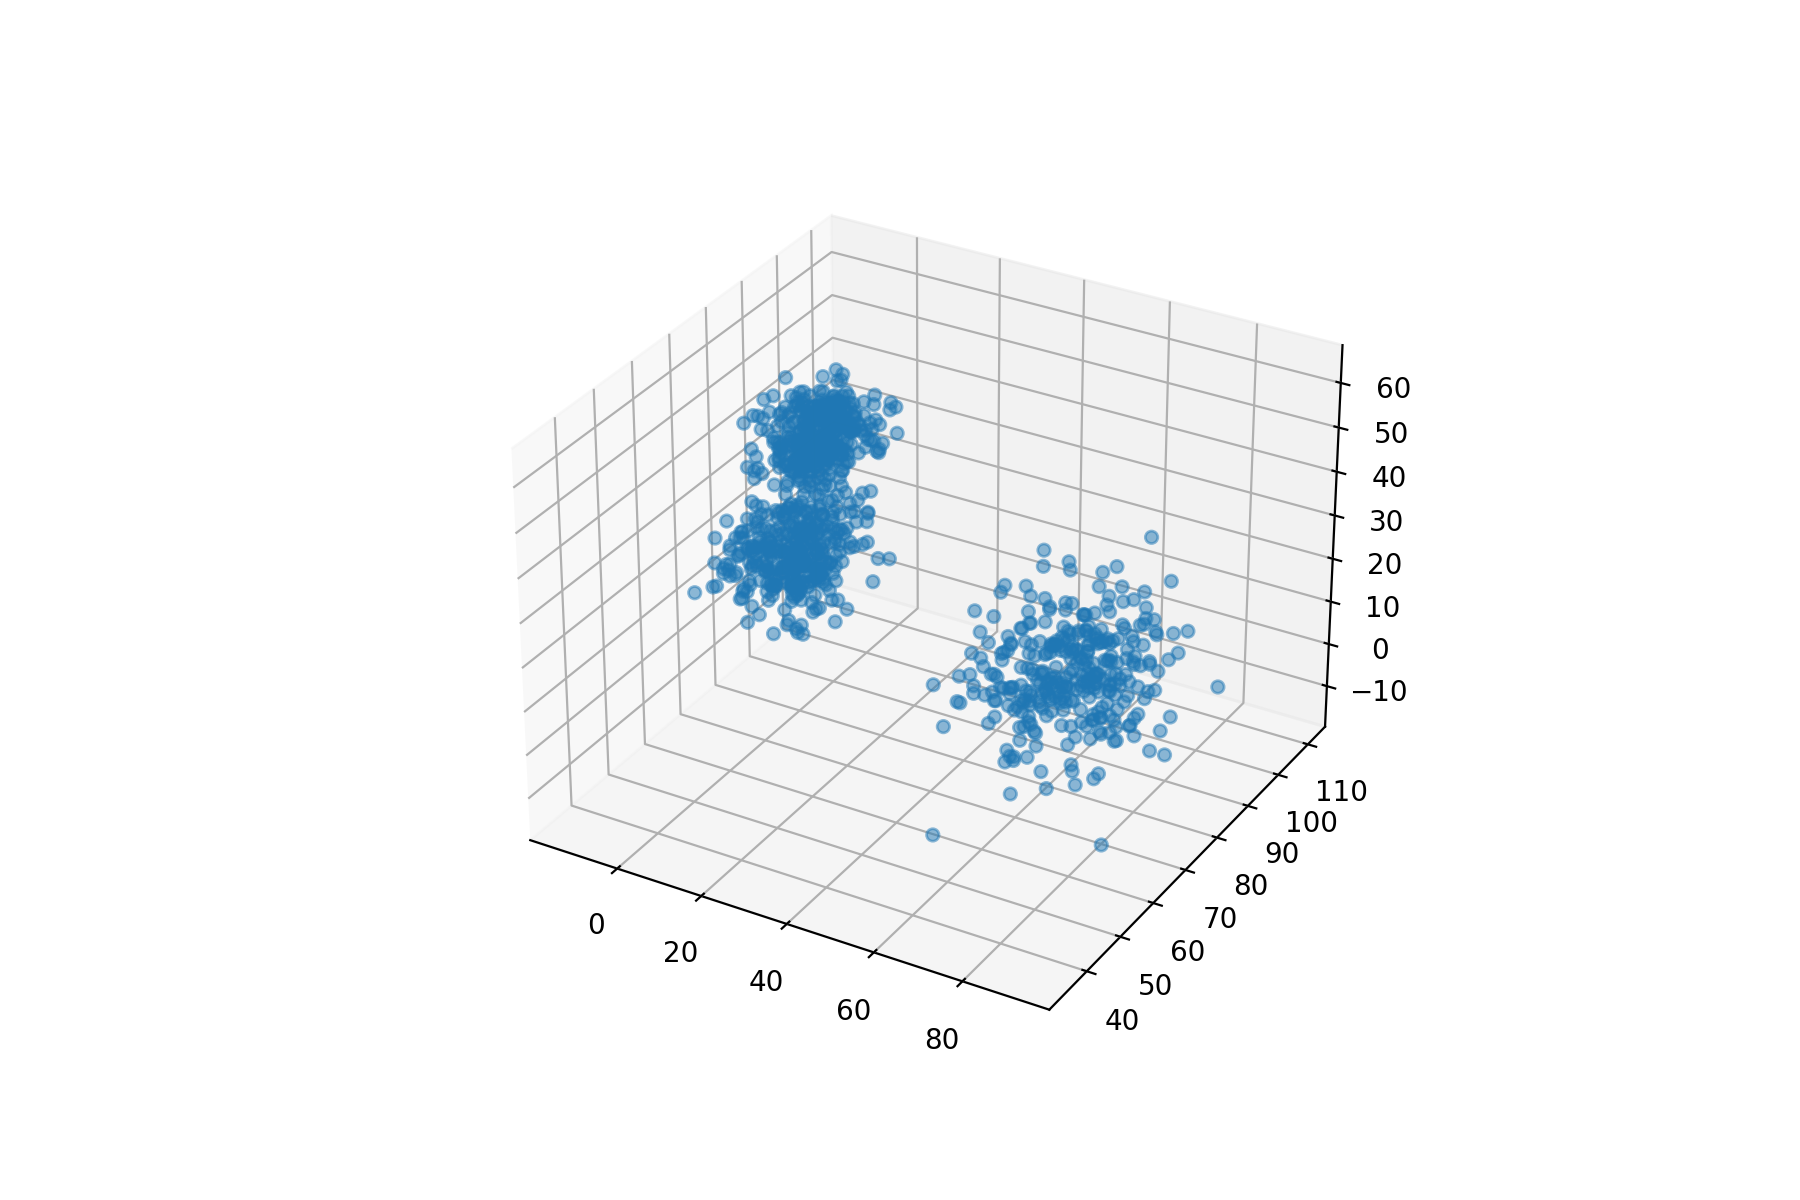

In [3]:
# посмотрим на эти точки на графике
ax = plt.figure(figsize=(9, 6)).add_subplot(projection='3d')
ax.scatter(df['a'], df['b'], df['c'], alpha=0.5)
plt.show()

## Выбор начального приближения
Первый вопрос при выборе начального положения центров — как, выбирая центры из некоторого случайного распределения, не попасть в область пространства признаков, где нет точек выборки. Базовое решение — просто выбрать в качестве центров какие-то из объектов выборки.

Вторая потенциальная проблема — кучное размещение центров. В этом случае их начальное положение с большой вероятностью окажется далёким от итогового положения центров кластеров. Например, для таких изначальных положений центров
<img src="https://raw.githubusercontent.com/teacher57/data_analysis_course/main/files/l6p2.png" width="500" height="500">
мы получим неправильную кластеризацию.
<img src="https://raw.githubusercontent.com/teacher57/data_analysis_course/main/files/l6p3.png" width="500" height="500">
Чтобы бороться с этим явлением, выгодно брать максимально удаленные друг от друга центры.

In [10]:
# создаю случайные центры
centers = l6.create_centers(df, 3) # указываю то количество кластеров, которое увидел на графике
centers

,a,b,c
0,40.097868,87.300086,14.817533
1,63.667652,40.207636,9.001134
2,90.906401,68.652853,41.264349


In [5]:
# добавляю столбец cluster в фрейм
df = l6.clusterize(df, centers)
df

,a,b,c,cluster
0,23.930622,45.092272,47.516331,0
1,17.903794,50.761324,44.080893,2
2,25.025400,48.884737,51.659121,2
3,55.853393,77.206360,-1.510056,2
4,75.754164,74.613253,1.733055,2
...,...,...,...,...
995,59.862354,91.319482,12.400906,2
996,77.356163,73.099419,8.895489,2
997,56.228739,65.509968,10.863755,0
998,9.779675,81.483200,42.114361,2


<IPython.core.display.Javascript object>


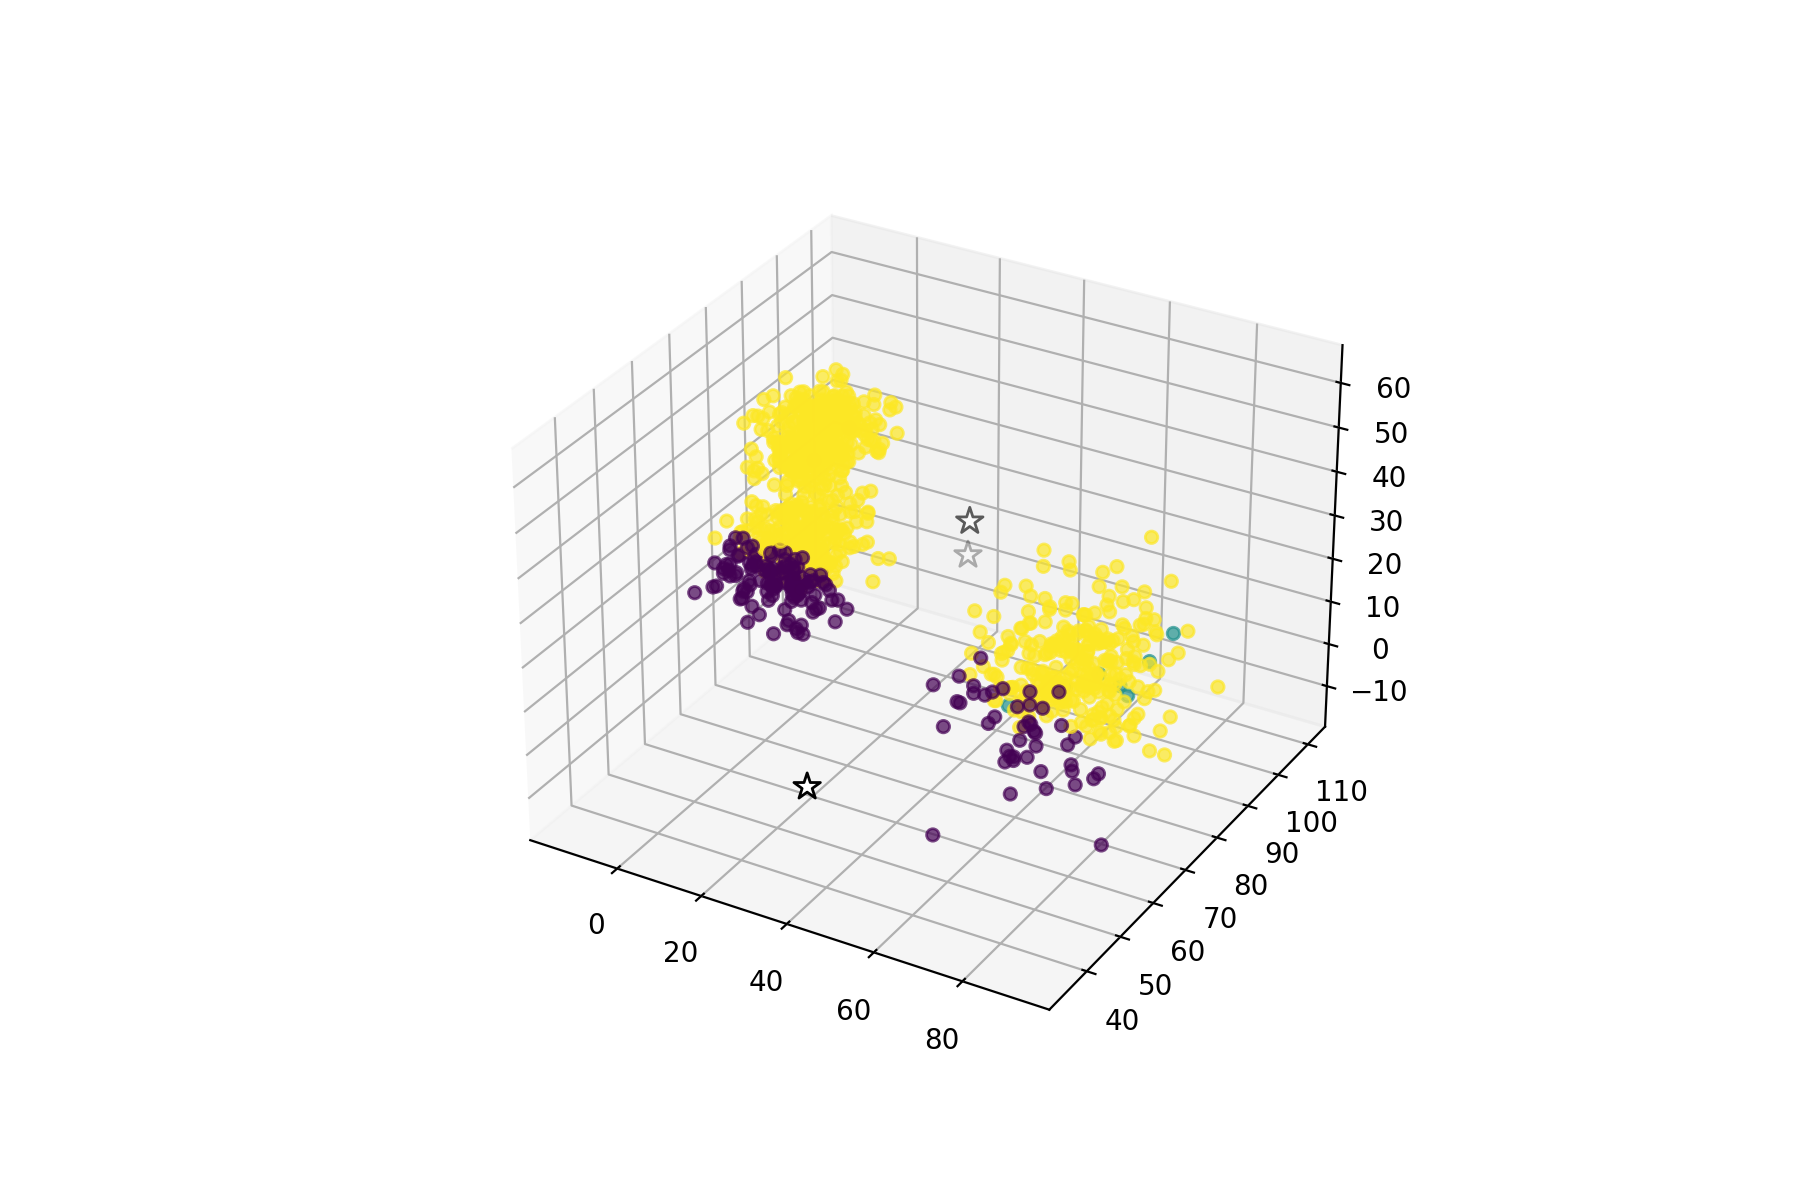

In [6]:
# график с центрами кластеров, как они сейчас расставлены
ax = plt.figure(figsize=(9, 6)).add_subplot(projection='3d')

ax.scatter(centers['a'], centers['b'], centers['c'], c="white", marker="*", s=100, edgecolors='black')
ax.scatter(df['a'], df['b'], df['c'], alpha=0.7, c=df["cluster"])
plt.show()

А теперь перерасставим центры кластеров. Пересчитаем расстояния от центра каждого кластера до каждой из его точек. Сформируем результирующий вектор и подвинем каждый из кластеров на этот результирующий вектор.

In [11]:
centers = l6.move_centers(df, centers)
centers
# новые центры

,a,b,c
0,25.894987,73.897443,34.001416
1,41.555876,51.745217,31.985426
2,78.413384,77.462930,15.231488


In [12]:
# заново расставляем столбец cluster
df = l6.clusterize(df, centers)
df

,a,b,c,cluster
0,23.930622,45.092272,47.516331,1
1,17.903794,50.761324,44.080893,0
2,25.025400,48.884737,51.659121,1
3,55.853393,77.206360,-1.510056,2
4,75.754164,74.613253,1.733055,2
...,...,...,...,...
995,59.862354,91.319482,12.400906,2
996,77.356163,73.099419,8.895489,2
997,56.228739,65.509968,10.863755,2
998,9.779675,81.483200,42.114361,0


<IPython.core.display.Javascript object>


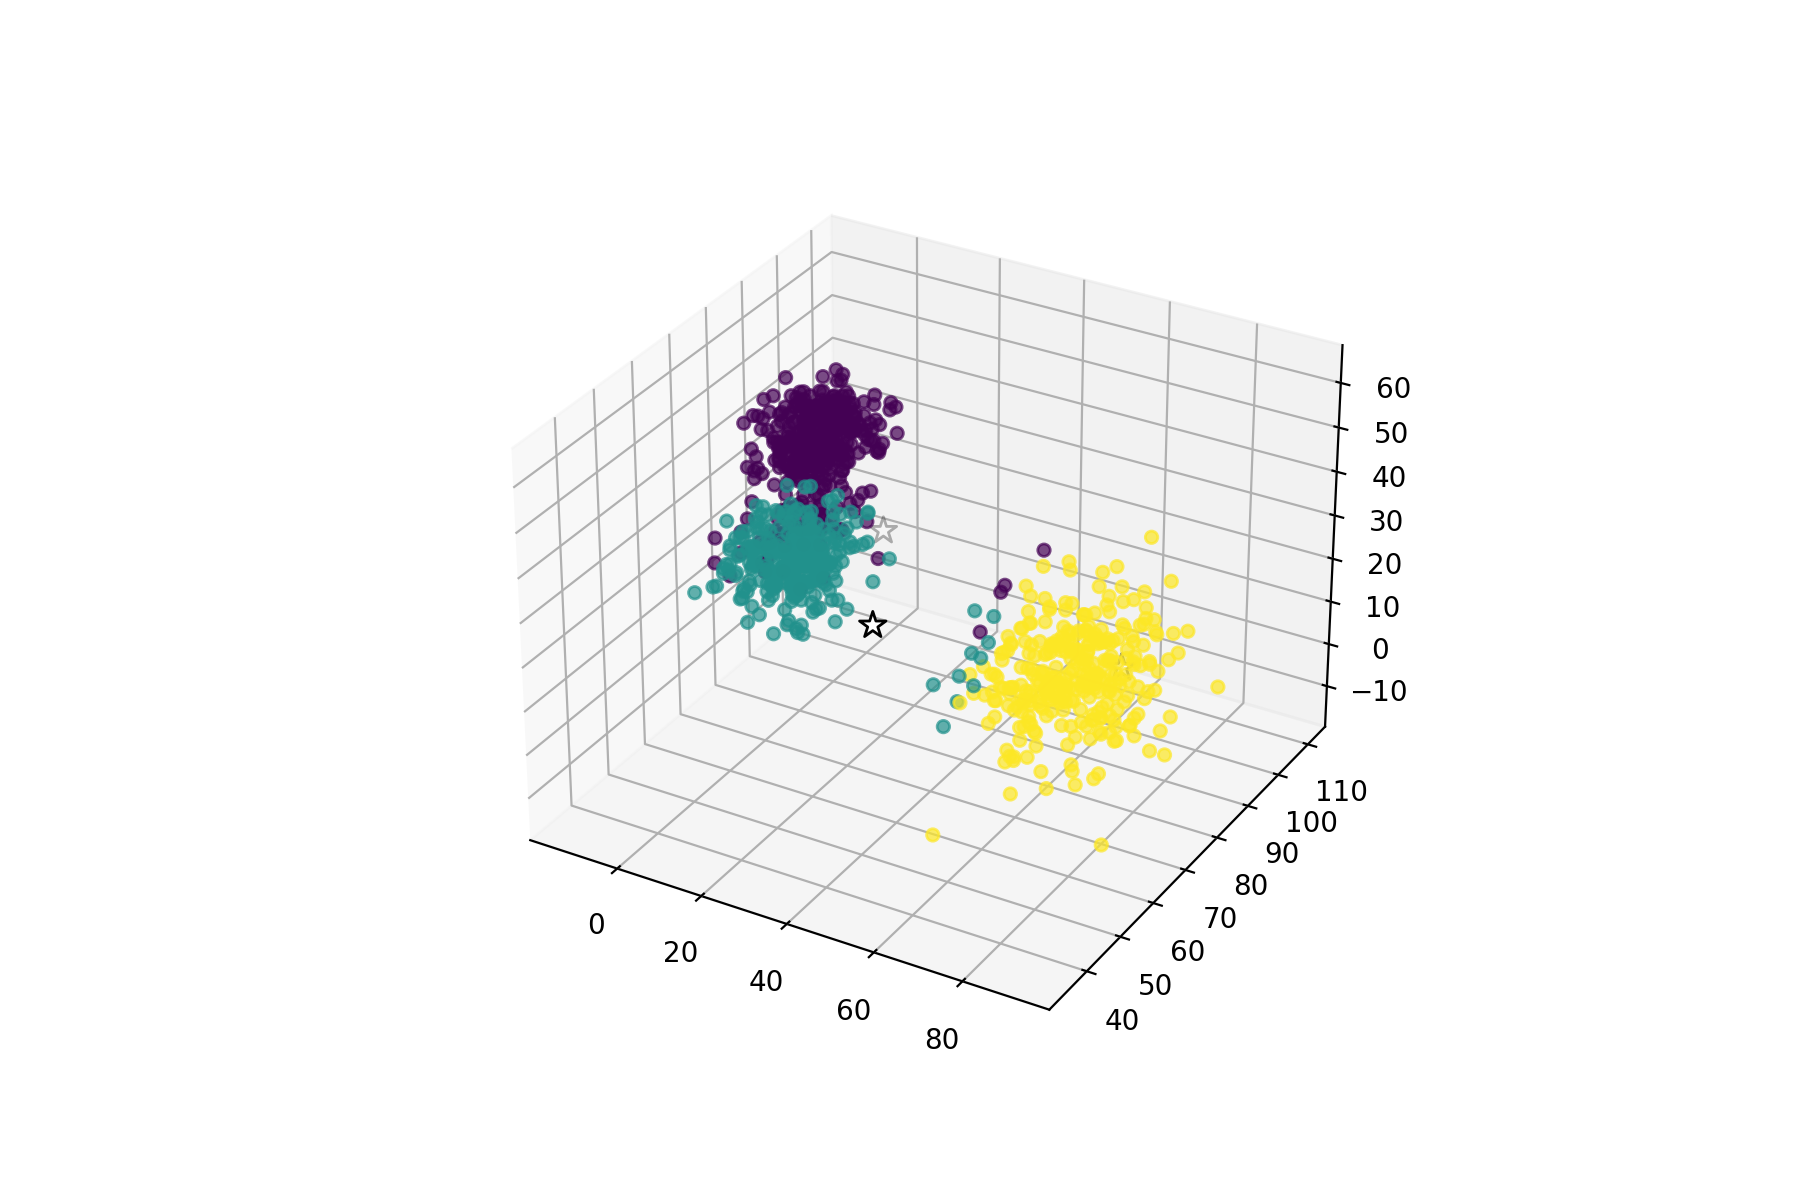

In [13]:
# снова график
ax = plt.figure(figsize=(9, 6)).add_subplot(projection='3d')

ax.scatter(centers['a'], centers['b'], centers['c'], c="white", marker="*", s=100, edgecolors='black')
ax.scatter(df['a'], df['b'], df['c'], alpha=0.7, c=df["cluster"])
plt.show()

<IPython.core.display.Javascript object>


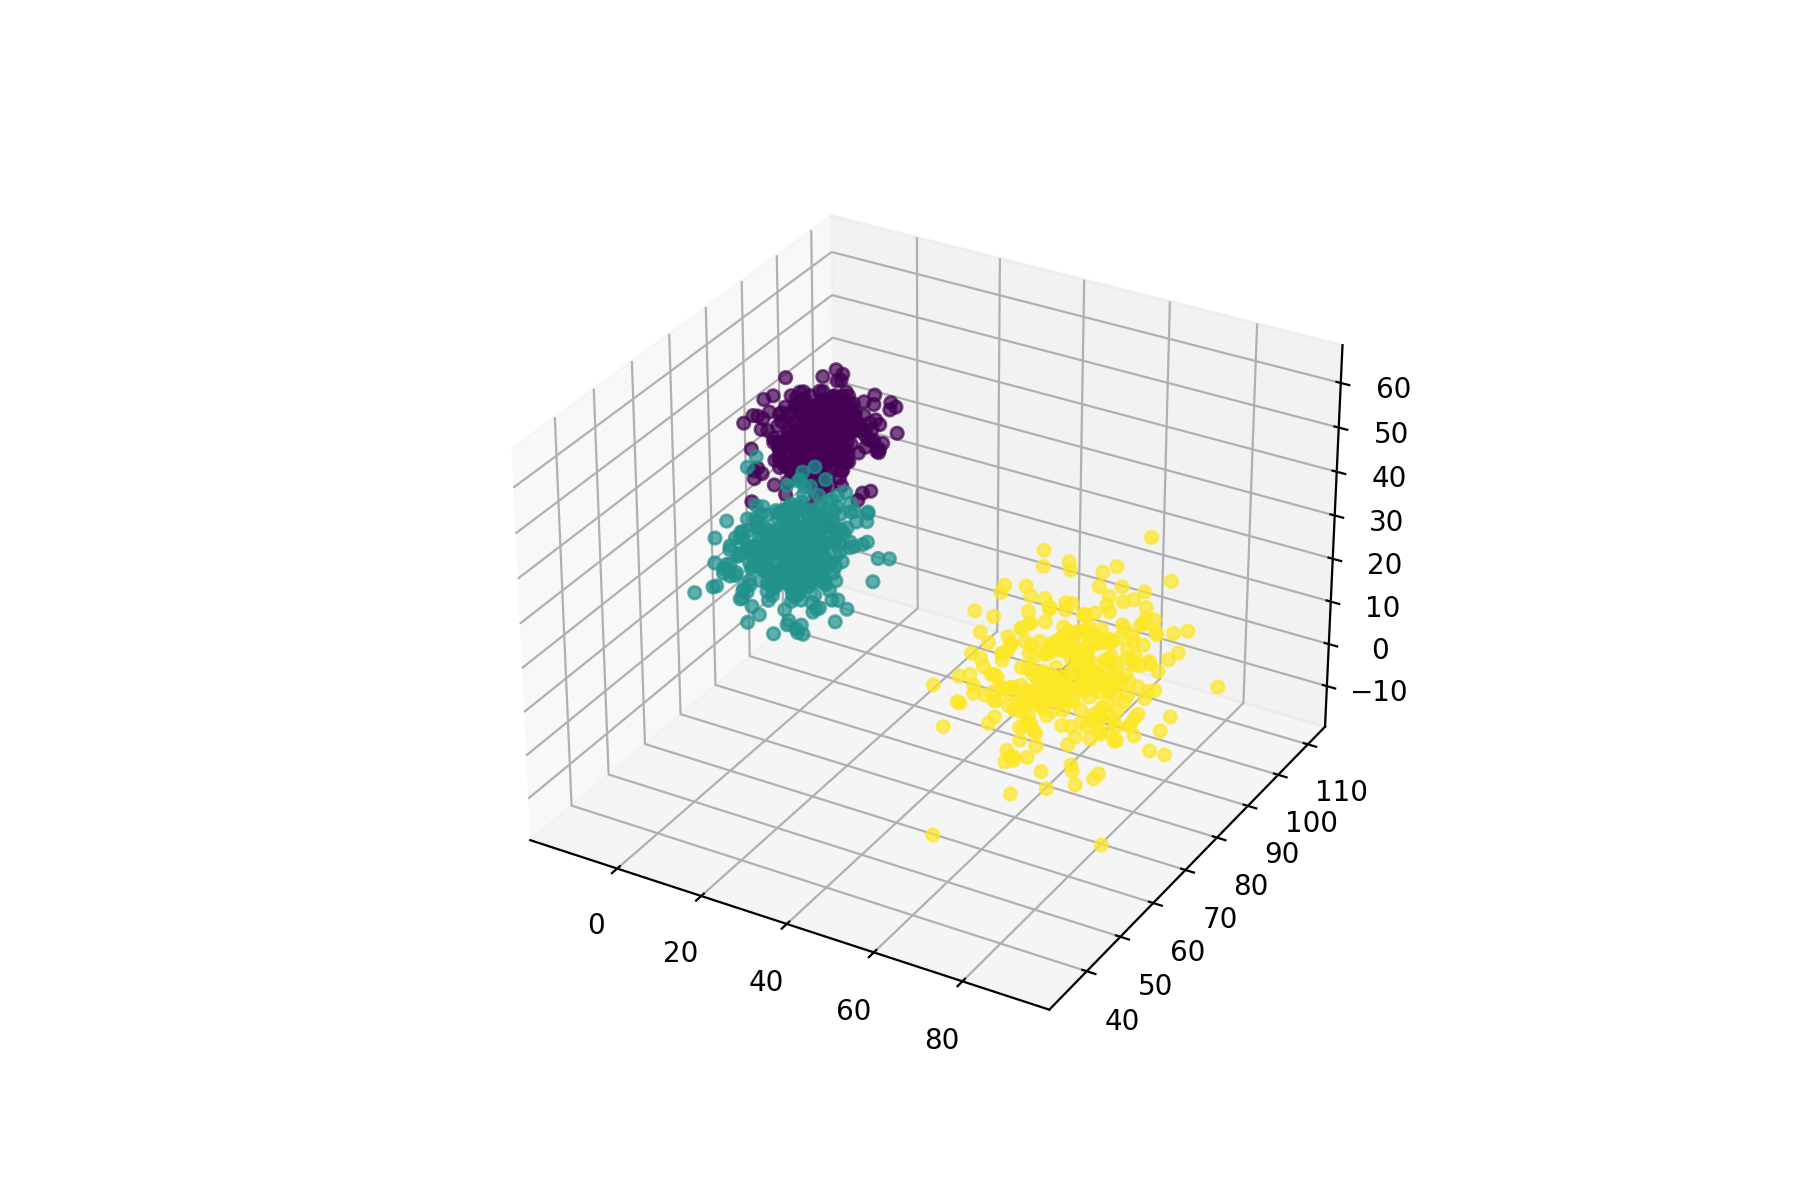

In [17]:
# проделаем так еще несколько раз и центры окончательно встанут на места
for i in range(5):
    centers = l6.move_centers(df, centers)
df = l6.clusterize(df, centers)

ax = plt.figure(figsize=(9, 6)).add_subplot(projection='3d')

ax.scatter(centers['a'], centers['b'], centers['c'], c="white", marker="*", s=100, edgecolors='black')
ax.scatter(df['a'], df['b'], df['c'], alpha=0.7, c=df["cluster"])
plt.show()

---
# Пара моментов

## Как посчитать расстояние между двумя точками
Расстояние между двумя точками – Евклидово, то есть ищется по формуле
$$ \sqrt{(x_1 - x_2) ^ 2 + (y_1 - y_2) ^ 2}, $$ где $x_1$ и $y_1$, $x_2$ и $y_2$ это координаты двух точек. 

В случае, когда осей больше двух: 
$$ \sqrt{\sum_{i=1}^n (a_i - b_i) ^ 2}, $$ где *a* и *b* – точки с координатами $ (a_1, a_2... a_n) $ и $ (b_1, b_2... b_n) $.

Для примера посчитаем расстояние между двумя точками.

In [26]:
df1 = l6.gen(5, N_ROWS=2)
df1

,a,b,c,d,e,cluster
0,86.629161,26.947834,44.651728,-0.597717,83.678195,2
1,89.271643,53.749007,39.124357,20.741712,83.879048,2


Столбец *cluster* пока можно игнорировать. Допустим, что одна из этих точек – наш центр, а вторая – одна из точек выборки. Нам нужно найти расстояние между ними.

In [27]:
# записал точки в переменные
a = df1.loc[0][:-1]
b = df1.loc[1][:-1]
a, b

(a    86.629161
 b    26.947834
 c    44.651728
 d    -0.597717
 e    83.678195
 Name: 0, dtype: float64,
 a    89.271643
 b    53.749007
 c    39.124357
 d    20.741712
 e    83.879048
 Name: 1, dtype: float64)

In [28]:
# посчитал Евклидово расстояние
s = 0
for i in range(a.size):
    s += (a[i] - b[i]) ** 2

np.sqrt(s)

34.8030026416825

## Как получить результирующий вектор

In [29]:
df2 = l6.gen(N_ROWS=4)
df2

,a,b,cluster
0,43.453515,49.143660,1
1,105.822617,39.155865,2
2,42.231481,46.263037,1
3,89.478957,38.420069,2


Пускай у нас есть 4 точки. Столбец *cluster* пока не имеет значения. Допустим, наш центр стоял на координатах (50, 50), посчитаем, куда и на сколько ему нужно сдвинуться.

In [30]:
center = [50, 50]
res_vector = [0, 0] # здесь будет результирующий вектор

# так находим сумму
for i, row in df2.iterrows():
    res_vector[0] += row[0] - center[0]
    res_vector[1] += row[1] - center[1]

# так находим среднее (потому что 4 строчки)
res_vector[0] /= 4 
res_vector[1] /= 4

res_vector

[20.246642635047866, -6.754342275407652]

Эти два числа показывают, на сколько нужно сдвинуть центр по каждой из координат.

## Перейдем к коду
Для этого урока я написал библиотеку, итогом ближайших уроков будет то, что и ты напишешь такую же.

### Первая функция, 
которая пригодится, это создание центров, то есть генерация случайных точек в пределах выборки. Их можно случайно из самой выборки. 

In [31]:
# допустим, выборка будет такая
# пока что хватит и двух точек

df = l6.gen(4, N_ROWS=2).drop("cluster", axis=1) # использую drop, чтобы не было столбца с номерами кластеров
df

,a,b,c,d
0,108.522999,42.230871,81.719234,27.307924
1,86.261572,29.527742,94.434433,41.115823


Сколько кластеров в выборке из двух точек? - Очевидно, два!

In [32]:
# создадим случайные центры

centers = l6.create_centers(df, 2) 
# в эту функцию дается две переменные
# выборка, на основе которой нужны центры и количество центров

centers

,a,b,c,d
0,94.728266,42.145683,92.056700,40.20783
1,97.635976,31.773661,87.194992,35.25593


Теперь это два центра наших кластера, вот и все, что должна делать такая функция. Ей дают фрейм точек и необходимое количество центров, она возвращает фрейм центров.

### Вторая функция
– расчет расстояния между двумя точками (математическая функция приведена выше). Посчитаем расстояние между этими центрами.

In [33]:
# координаты первого центра
a = centers.loc[0]
a

a    94.728266
b    42.145683
c    92.056700
d    40.207830
Name: 0, dtype: float64

In [34]:
# координаты второго центра
b = centers.iloc[1]
b

a    97.635976
b    31.773661
c    87.194992
d    35.255930
Name: 1, dtype: float64

In [35]:
# расстояние между ними
l6.distance(a, b)

12.813708478344708

Получается, функция distance берет на вход два обьекта типа *Series* и возвращает значение по математической формуле.

### Третья функция
– нахождение ближайшего центра для конкретной точки.

In [36]:
# возьму первую точку из фрейма
a = df.iloc[0]
a

a    108.522999
b     42.230871
c     81.719234
d     27.307924
Name: 0, dtype: float64

In [37]:
# суну ее в функцию, для определения ближайшего к ней центра
l6.get_closest_center(a, df)

0

Функция выдала 0, это значит, что ближайший центр – нулевая строка в фрейме centers. То есть функция берет на вход обьект типа *Series* (точку) и обьект типа *DataFrame* (центры), считает расстояния до каждого центра, с помощью функции *distance*, которую мы только что разобрали, и выдает номер центра, который выдал наименьшее значение расстояния.



---

## Задачи для самостоятельного выполнения

Дедлайн 14ноя23 23:59.

В домашней работе нужно будет реализовать функции *create_centers()*, *distance()* и *get_closest_center()* аналогичные функциям, представленным в уроке. Можно на данных [отсюда](https://raw.githubusercontent.com/teacher57/data_analysis_course/main/files/l6t1.csv) и [отсюда](https://raw.githubusercontent.com/teacher57/data_analysis_course/main/files/l6t2.csv).

In [38]:
# файл l6t1.csv
df = read_csv("https://raw.githubusercontent.com/teacher57/data_analysis_course/main/files/l6t1.csv")
df

,a,b,c,d,e,f
0,29.962714,52.700518,30.579543,33.127484,40.964572,97.700194
1,34.849621,61.962314,27.376590,27.644068,43.921994,98.755396
2,34.262419,59.437003,19.768703,31.118479,43.219664,95.693131
3,32.743049,57.989251,18.986164,31.721485,57.503373,97.281464
4,34.269969,55.996434,27.998300,32.567611,52.654555,99.035943


In [39]:
# для этого фрейма
for i in range(1, 4):
    print(f"Расстояние от df.iloc[0] до df.iloc[{i}]: {l6.distance(df.iloc[0], df.iloc[i])}")

Расстояние от df.iloc[0] до df.iloc[1]: 12.643151970793427
Расстояние от df.iloc[0] до df.iloc[2]: 13.92450413427525
Расстояние от df.iloc[0] до df.iloc[3]: 21.113775590501408


In [40]:
# файл l6t2.csv
centers = read_csv("https://raw.githubusercontent.com/teacher57/data_analysis_course/main/files/l6t2.csv")
centers

,a,b,c,d,e,f
0,32.325244,55.562068,25.854669,32.472193,50.374167,98.005867
1,34.556020,60.699658,23.572646,29.381273,43.570829,97.224263


In [41]:
# по этой таблице можно свериться, какому кластеру принадлежит каждая точка
df["cluster"] = Series([0] * df.shape[0])
for i in range(5):
    df.at[i, "cluster"] = l6.get_closest_center(df.iloc[i], centers)
df

,a,b,c,d,e,f,cluster
0,29.962714,52.700518,30.579543,33.127484,40.964572,97.700194,0
1,34.849621,61.962314,27.376590,27.644068,43.921994,98.755396,1
2,34.262419,59.437003,19.768703,31.118479,43.219664,95.693131,1
3,32.743049,57.989251,18.986164,31.721485,57.503373,97.281464,0
4,34.269969,55.996434,27.998300,32.567611,52.654555,99.035943,0
